# QA Metrics

In [1]:
%matplotlib agg
import io
import os
import re
import time
import json
import pickle
import hashlib
import tarfile
import requests
import tempfile
import warnings
import functools
import contextlib
import subprocess
from pathlib import Path

import bs4
import docker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation
import natsort as ns
import tqdm.notebook as tqdm

from loguru import logger
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown, HTML, Video

from graphqa.data.aminoacids import *
from graphqa.metrics import rmse, r2_score, pearson, spearmanr, kendalltau, zscore, first_rank_loss, ktop_rank_loss
from graphqa.metrics import groupby_apply, compute_global_metrics, compute_local_metrics
from graphqa.utils.casp import convert_lddt_to_distance

## Global GDT-TS

Compare predicted GDT-TS scores with ground-truth GDT-TS scores obtained by comparison with the native structure.

In [2]:
def load_qa_global_true(casp_ed):
    df_global = []
    for p in Path(f'CASP{casp_ed}/decoys/').glob('*.tmscore.npz'):
        target_id = p.with_suffix('').with_suffix('').name
        d = np.load(p)
        df_global.extend([
            (target_id, decoy_id, gdtts)
            for decoy_id, gdtts in zip(d['decoys'], d['gdt_ts'])
        ])
        
    df_global = pd.DataFrame(df_global, columns=['target_id', 'decoy_id', 'true'])
    df_global = df_global.set_index(['target_id', 'decoy_id']).sort_index()
    return df_global

df = load_qa_global_true(casp_ed=13)
display(df)
display(
    df.groupby('target_id')
    .size()
    .astype(int)
    .to_frame('decoys')
)
del df

true
target_id decoy_id                 
T0949     3D-JIGSAW_SL1_TS1  0.1725
          3D-JIGSAW_SL1_TS2  0.1996
          3D-JIGSAW_SL1_TS3  0.1725
          3D-JIGSAW_SL1_TS4  0.1938
          3D-JIGSAW_SL1_TS5  0.1453
...                             ...
T1022s2   slbio_server_TS1   0.4618
          slbio_server_TS2   0.4514
          slbio_server_TS3   0.4216
          slbio_server_TS4   0.4598
          slbio_server_TS5   0.4177

[12970 rows x 1 columns]

,decoys
target_id,
T0949,159
T0950,183
T0951,155
T0953s1,165
T0953s2,171
...,...
T1021s1,185
T1021s2,176
T1021s3,180


In [4]:
def load_qa_global_pred(casp_ed):
    df_global = pd.read_pickle(f'CASP{casp_ed}/QA_predictions/global.pkl.xz')
    df_global = df_global.reset_index('stage').query('stage==2').drop(columns='stage')
    return df_global

df = load_qa_global_pred(casp_ed=13)
display(df)
display(
    df.groupby(['qa_group_id', 'target_id'])
    .size()
    .astype(int)
    .to_frame('decoys')
)
del df

pred
qa_group_id target_id decoy_id                    
3DCNN       T0962     1270-5526-8383_TS1  0.369067
                      1270-5526-8383_TS2  0.353299
                      1270-5526-8383_TS3  0.362075
                      1270-5526-8383_TS4  0.399744
                      1312-6135-4624_TS1  0.655809
...                                            ...
Yang-Server T0949     Zhang-Server_TS1    0.374000
                      Zhang-Server_TS2    0.262000
                      Zhang-Server_TS3    0.360000
                      Zhang-Server_TS4    0.365000
                      Zhang-Server_TS5    0.392000

[629629 rows x 1 columns]

decoys
qa_group_id target_id        
3DCNN       T0962         150
            T0969         150
            T0970         150
            T0971         150
            T0972         150
...                       ...
Wallner     T1021s2       150
            T1021s3       150
            T1022s1       150
            T1022s2       150
Yang-Server T0949         150

[4209 rows x 1 columns]

In [34]:
@logger.catch(reraise=True)
def compute_metrics(df_score):
    if df_score.size == 0:
        logger.warning(f'Empty dataframe')
        return None
    # If all true scores are NaN, there is an error on our side
    if df_score['true'].isna().all():
        logger.warning(f'All true scores are NaN\n{df_score}')
        return None
    # If all pred scores are NaN, there is an error on the QA group's side
    if df_score['pred'].isna().all():
        logger.warning(f'All predicted scores are NaN\n{df_score}')
        return None
    
    # Can only compute metrics where we have both the true and predicted scores
    df = df_score.dropna(axis="index", how='any', subset=["true", "pred"])
    pred = df["pred"]
    true = df["true"]
    return pd.Series(
        {
            "RMSE": rmse(pred, true),
            "R2": r2_score(pred, true),
            "R": pearson(pred, true),
            "ρ": spearmanr(pred, true),
            "τ": kendalltau(pred, true),
            "z": zscore(pred, true),
            "FRL": first_rank_loss(pred, true),
            "top5": ktop_rank_loss(pred, true, k=5),
        }
    )

def foo(df_scores):
    # df_scores contains all predictions for a certain QA group
    # made for all decoys of all targets of a certain CASP year
    df_metrics_global = compute_metrics(df_scores)
    df_metrics_global_per_target = df_scores.groupby('target_id').apply(compute_metrics).mean()
    return pd.concat(
        (df_metrics_global, df_metrics_global_per_target), 
        axis=0, 
        keys=['global', 'global_per_target'],
    ).rename_axis(['agg', 'metric'])

for casp_ed in [13]:
    df_qa_global_true = load_qa_global_true(casp_ed)
    df_qa_global_pred = load_qa_global_pred(casp_ed)
    df_metrics = {}
    
    if casp_ed == 13:
        our_pred_global = pd.read_pickle('runs/wandb/quirky_stallman_1133/test_scores.pkl', compression='xz')['global']['gdtts'][['pred']]
        our_pred_global = pd.concat((our_pred_global,), keys=['GraphQA'], names=['qa_group_id'])
        df_qa_global_pred = pd.concat((df_qa_global_pred, our_pred_global))
    
    for qa_group_id, df_qa_global_pred_group in df_qa_global_pred.groupby('qa_group_id'):
        if qa_group_id == 'OccuScore':
            continue
        df_scores = pd.merge(
            df_qa_global_true,
            df_qa_global_pred_group,
            left_index=True,
            right_index=True,
            how='inner'
        )
        #display(foo(df_scores))
        df_m = foo(df_scores)
        if df_m is not None:
            df_metrics[qa_group_id] = df_m
    
    df_metrics = pd.concat(df_metrics.values(), keys=df_metrics.keys(), names=['qa_group_id'])
    df_metrics = df_metrics.unstack('qa_group_id').transpose()
    df_metrics.sort_values(('global', 'R'), inplace=True, ascending=False)
    df_metrics.sort_index('columns', inplace=True)
    
    display(
        df_metrics
        .style
        .background_gradient(axis=0, subset=[('global', 'R'), ('global_per_target', 'R')])
        .set_caption(f'CASP {casp_ed} (all metrics)')
        .format('{:.3f}')
    )
    
    display(
        df_metrics[[
            ('global', 'R'),
            ('global', 'RMSE'),
            ('global_per_target', 'R'),
            ('global_per_target', 'RMSE'),
            ('global_per_target', 'z'),
            ('global_per_target', 'FRL'),
            ('global_per_target', 'top5'),
        ]]
        .style
        .background_gradient(axis=0, subset=[('global', 'R'), ('global_per_target', 'R')])
        .set_caption(f'CASP {casp_ed} (fewer metrics)')
        .format('{:.3f}')
    )

/home/fedbal/miniconda3/envs/proteins_new/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/fedbal/miniconda3/envs/proteins_new/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/fedbal/miniconda3/envs/proteins_new/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/fedbal/miniconda3/envs/proteins_new/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/fedbal/miniconda3/envs/proteins_new/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/f

## Local scores

Compare predicted LDDT and CAD score with the respective ground-truth computed using the native structure.

CASP submissions made by other groups don't have predicted scores available, thus only a correlation metric can be computed.

In [6]:
def load_qa_local_true(casp_ed):
    df_local = {}
    for p in Path(f'CASP{casp_ed}/decoys/').glob('*.lddt.npz'):
        target_id = p.with_suffix('').with_suffix('').name
        d = np.load(p)
        df_local[target_id] = pd.DataFrame(
            d['local_lddt'], 
            index=pd.Index(d['decoys'], name='decoy_id'), 
            columns=pd.RangeIndex(d['local_lddt'].shape[1], name='residue_idx')
        ).stack('residue_idx', dropna=False)
        
        
    df_local = pd.concat(df_local.values(), keys=df_local.keys(), names=['target_id']).sort_index().to_frame('true')
    return df_local

df = load_qa_local_true(casp_ed=13)
display(df)
display(
    df.reset_index(level='decoy_id')
    .groupby('target_id')
    .agg({'decoy_id': 'nunique'})
    .rename(columns={'decoy_id': 'decoys'})
    .astype(int)
)
del df

true
target_id decoy_id          residue_idx          
T0949     3D-JIGSAW_SL1_TS1 0                 NaN
                            1                 NaN
                            2                 NaN
                            3                 NaN
                            4                 NaN
...                                           ...
T1022s2   slbio_server_TS5  524          0.359274
                            525          0.433784
                            526          0.322984
                            527               NaN
                            528               NaN

[4373935 rows x 1 columns]

,decoys
target_id,
T0949,159
T0950,183
T0951,155
T0953s1,165
T0953s2,171
...,...
T1021s1,185
T1021s2,176
T1021s3,180


In [2]:
def load_qa_local_pred(casp_ed):
    df_local = pd.read_pickle(f'CASP{casp_ed}/QA_predictions/local.pkl.xz')
    df_local = df_local.loc[pd.IndexSlice[:,:,:,2, :], :].droplevel(level='stage', axis=0)
    return df_local

df = load_qa_local_pred(casp_ed=13)
display(df)
del df

pred
qa_group_id target_id decoy_id           residue_idx          
3DCNN       T0962     1270-5526-8383_TS1 0            2.779862
                                         1            3.369109
                                         2            1.471484
                                         3            2.124728
                                         4            1.437495
...                                                        ...
Yang-Server T0949     Zhang-Server_TS5   178          1.120000
                                         179          1.960000
                                         180          2.430000
                                         181          3.360000
                                         182          4.640000

[98715604 rows x 1 columns]

In [58]:
def compute_metrics(df_score):
    from loguru import logger
    if df_score.size == 0:
        logger.warning(f'Empty dataframe')
        return None
    # If all true scores are NaN, there is an error on our side
    if df_score['true'].isna().all():
        logger.warning(f'All true scores are NaN\n{df_score}')
        return None
    # If all pred scores are NaN, there is an error on the QA group's side
    if df_score['pred'].isna().all():
        logger.warning(f'All predicted scores are NaN\n{df_score}')
        return None
    
    # Can only compute metrics where we have both the true and predicted scores
    df = df_score.dropna(axis="index", how='any', subset=["true", "pred"])
    pred = df["pred"]
    true = df["true"]
    return pd.Series(
        {
            "RMSE": rmse(pred, true),
            #"R2": r2_score(pred, true),
            "R": pearson(pred, true),
            "ρ": spearmanr(pred, true),
            #"τ": kendalltau(pred, true),
            #"z": zscore(pred, true),
            #"FRL": first_rank_loss(pred, true),
            #"top5": ktop_rank_loss(pred, true, k=5),
        }
    )

def foo(df_scores):
    # df_scores contains all predictions for a certain QA group
    # made for all decoys of all targets of a certain CASP year
    df_metrics_local = compute_metrics(df_scores)
    df_metrics_local_per_decoy = (
        groupby_apply(
            df_scores, ["target_id", "decoy_id"], compute_metrics, n_jobs=10
        )
        .unstack(level=2)
        .mean()
    )
    return pd.concat(
        (df_metrics_local, df_metrics_local_per_decoy), 
        axis=0, 
        keys=['local', 'local_per_decoy'],
    ).rename_axis(['agg', 'metric'])

for casp_ed in [13]:
    df_qa_local_true = load_qa_local_true(casp_ed)
    df_qa_local_pred = load_qa_local_pred(casp_ed)
    df_metrics = {}
    # display(df_qa_local_true)
    
    if casp_ed == 13:
        ours_pred_local = pd.read_pickle('runs/wandb/quirky_stallman_1133/test_scores.pkl', compression='xz')['local']['lddt'][['pred']]
        ours_pred_local['residue_idx'] = np.concatenate([
            np.arange(s)
            for s in ours_pred_local.groupby(['target_id', 'decoy_id']).size()
        ])
        ours_pred_local.set_index('residue_idx', append=True, inplace=True)
        ours_pred_local = pd.concat((ours_pred_local,), keys=['GraphQA'], names=['qa_group_id'])
        df_qa_local_pred = pd.concat((df_qa_local_pred, ours_pred_local))
    
    for qa_group_id, df_qa_local_pred_group in df_qa_local_pred.groupby('qa_group_id'):
        if qa_group_id == 'OccuScore':
            continue
        #display(df_qa_local_pred_group)
        df_scores = pd.merge(
            df_qa_local_true,
            df_qa_local_pred_group.droplevel('qa_group_id', axis=0),
            left_index=True,
            right_index=True,
            how='inner'
        )
        #display(df_scores)
        df_m = foo(df_scores)
        if df_m is not None:
            df_metrics[qa_group_id] = df_m
    
    df_metrics = pd.concat(df_metrics.values(), keys=df_metrics.keys(), names=['qa_group_id'])
    df_metrics = df_metrics.unstack('qa_group_id').transpose()
    df_metrics.sort_values(('local', 'ρ'), inplace=True, ascending=False)
    df_metrics.sort_index('columns', inplace=True)
    
    display(
        df_metrics
        .style
        .background_gradient(axis=0, subset=[('local', 'ρ'), ('local_per_decoy', 'ρ')])
        .set_caption(f'CASP {casp_ed} (all metrics)')
        .format('{:.3f}')
    )
    
#     display(
#         df_metrics[[
#             ('local', 'R'),
#             ('local', 'RMSE'),
#             ('local_per_decoy', 'R'),
#             ('local_per_decoy', 'RMSE'),
#         ]]
#         .style
#         .background_gradient(axis=0, subset=[('local', 'R'), ('local_per_decoy', 'R')])
#         .set_caption(f'CASP {casp_ed} (fewer metrics)')
#         .format('{:.3f}')
#     )

## Local "distances" (CASP 13)

- Take LDDT and CAD predictions from GraphQA
- Convert them to CASP "distances" using:\
  $\text{dist} = \max\left(15,\ 5 \sqrt{\frac{1}{\text{score}} - 1}\right)$
- Compare with the ground-truth distances obtained from the CASP website

Ground truth distances

In [23]:
df_qa_local_true = pd.read_pickle('CASP13/QA_official/distances_true.pkl')
df_qa_local_true = df_qa_local_true[df_qa_local_true<20]
df_qa_local_true.to_frame()

true
target_id decoy_id           residue_idx        
T0949     5117-9799-8107_TS5 42            2.274
                             43            2.047
                             44            2.225
                             45            1.599
                             46            0.661
...                                          ...
T1022s2   3166-0463-8476_TS1 431          19.754
                             432          18.775
                             433          17.419
                             434          18.393
                             435          18.852

[5771454 rows x 1 columns]

GraphQA scores converted to distances

In [24]:
ours_pred_local_lddt = pd.read_pickle('../runs/wandb/quirky_stallman_1133/test_scores.pkl', compression='xz')['local']['lddt'][['pred']]
ours_pred_local_lddt = convert_lddt_to_distance(ours_pred_local_lddt)
ours_pred_local_lddt['residue_idx'] = np.concatenate([
    np.arange(s)
    for s in ours_pred_local_lddt.groupby(['target_id', 'decoy_id']).size()
])
ours_pred_local_lddt.set_index('residue_idx', append=True, inplace=True)
ours_pred_local_lddt = pd.concat((ours_pred_local_lddt,), keys=['GraphQA_LDDT'], names=['qa_group_id'])

ours_pred_local_cad = pd.read_pickle('../runs/wandb/quirky_stallman_1133/test_scores.pkl', compression='xz')['local']['cad'][['pred']]
ours_pred_local_cad = convert_lddt_to_distance(ours_pred_local_cad)
ours_pred_local_cad['residue_idx'] = np.concatenate([
    np.arange(s)
    for s in ours_pred_local_cad.groupby(['target_id', 'decoy_id']).size()
])
ours_pred_local_cad.set_index('residue_idx', append=True, inplace=True)
ours_pred_local_cad = pd.concat((ours_pred_local_cad,), keys=['GraphQA_CAD'], names=['qa_group_id'])

ours_pred_local = pd.concat((ours_pred_local_lddt, ours_pred_local_cad))
del ours_pred_local_lddt, ours_pred_local_cad
ours_pred_local

pred
qa_group_id  target_id decoy_id          residue_idx           
GraphQA_LDDT T0949     3D-JIGSAW_SL1_TS1 0             8.526910
                                         1             9.454096
                                         2             9.405398
                                         3             9.643991
                                         4             8.538031
...                                                         ...
GraphQA_CAD  T1022s2   slbio_server_TS5  524          13.572697
                                         525          11.286969
                                         526          15.000000
                                         527          14.335065
                                         528          13.387546

[6048322 rows x 1 columns]

Plot of our predictions

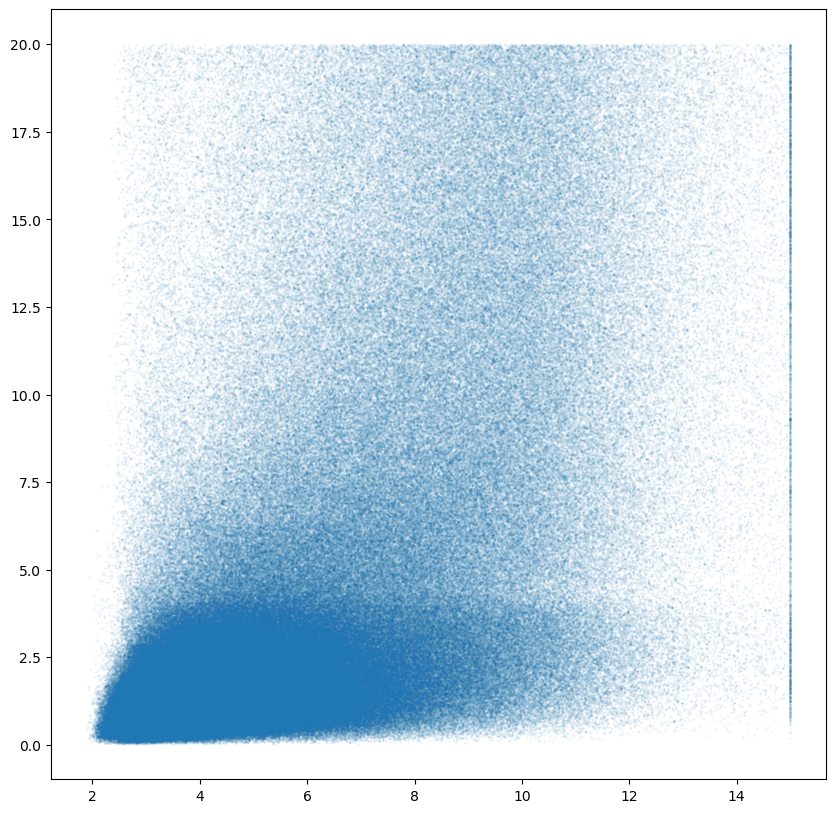

In [27]:
df_tmp = pd.merge(
    ours_pred_local.loc['GraphQA_LDDT', :],
    df_qa_local_true,
    left_index=True,
    right_index=True,
    how='inner'
)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(df_tmp['pred'], df_tmp['true'], s=1, alpha=.05)
display(fig)

Other groups

In [28]:
others_pred_local = load_qa_local_pred(casp_ed=13)
others_pred_local

pred
qa_group_id target_id decoy_id           residue_idx          
3DCNN       T0962     1270-5526-8383_TS1 0            2.779862
                                         1            3.369109
                                         2            1.471484
                                         3            2.124728
                                         4            1.437495
...                                                        ...
Yang-Server T0949     Zhang-Server_TS5   178          1.120000
                                         179          1.960000
                                         180          2.430000
                                         181          3.360000
                                         182          4.640000

[98715604 rows x 1 columns]

Computing metrics

In [6]:
def compute_metrics(df_score):
    from loguru import logger
    if df_score.size == 0:
        logger.warning(f'Empty dataframe')
        return None
    # If all true scores are NaN, there is an error on our side
    if df_score['true'].isna().all():
        logger.warning(f'All true scores are NaN\n{df_score}')
        return None
    # If all pred scores are NaN, there is an error on the QA group's side
    if df_score['pred'].isna().all():
        logger.warning(f'All predicted scores are NaN\n{df_score}')
        return None
    
    # Can only compute metrics where we have both the true and predicted scores
    df = df_score.dropna(axis="index", how='any', subset=["true", "pred"])
    
    # Somehow this breaks
    if len(df) <= 2:
        logger.warning(f'Too few points')
        return None
    
    pred = df["pred"]
    true = df["true"]
    return pd.Series(
        {
            "RMSE": rmse(pred, true),
            #"R2": r2_score(pred, true),
            "R": pearson(pred, true),
            "ρ": spearmanr(pred, true),
            #"τ": kendalltau(pred, true),
            #"z": zscore(pred, true),
            #"FRL": first_rank_loss(pred, true),
            #"top5": ktop_rank_loss(pred, true, k=5),
        }
    )

def foo(df_scores):
    # df_scores contains all predictions for a certain QA group
    # made for all decoys of all targets of a certain CASP year
    df_metrics_local = compute_metrics(df_scores)
    df_metrics_local_per_decoy = (
        groupby_apply(
            df_scores, ["target_id", "decoy_id"], compute_metrics, n_jobs=10
        )
        .unstack(level=2)
        .mean()
    )
    return pd.concat(
        (df_metrics_local, df_metrics_local_per_decoy), 
        axis=0, 
        keys=['local', 'local_per_decoy'],
    ).rename_axis(['agg', 'metric'])

df_metrics = {}
df_qa_local_pred = pd.concat((others_pred_local, ours_pred_local))

for qa_group_id, df_qa_local_pred_group in df_qa_local_pred.groupby('qa_group_id'):
    if qa_group_id == 'OccuScore':
        continue
    #display(df_qa_local_pred_group)
    df_scores = pd.merge(
        df_qa_local_true,
        df_qa_local_pred_group.droplevel('qa_group_id', axis=0),
        left_index=True,
        right_index=True,
        how='inner'
    )
    #display(df_scores)
    df_m = foo(df_scores)
    if df_m is not None:
        df_metrics[qa_group_id] = df_m

df_metrics = pd.concat(df_metrics.values(), keys=df_metrics.keys(), names=['qa_group_id'])
df_metrics = df_metrics.unstack('qa_group_id').transpose()
df_metrics.sort_values(('local', 'ρ'), inplace=True, ascending=False)
df_metrics.sort_index('columns', inplace=True)

display(
    df_metrics
    .style
    .background_gradient(axis=0, subset=[('local', 'ρ'), ('local_per_decoy', 'ρ')])
    .set_caption(f'CASP 13 (all metrics)')
    .format('{:.3f}')
)
    
#     display(
#         df_metrics[[
#             ('local', 'R'),
#             ('local', 'RMSE'),
#             ('local_per_decoy', 'R'),
#             ('local_per_decoy', 'RMSE'),
#         ]]
#         .style
#         .background_gradient(axis=0, subset=[('local', 'R'), ('local_per_decoy', 'R')])
#         .set_caption(f'CASP {casp_ed} (fewer metrics)')
#         .format('{:.3f}')
#     )

In [30]:
def compute_metrics(df_score):
    from loguru import logger
    if df_score.size == 0:
        logger.warning(f'Empty dataframe')
        return None
    # If all true scores are NaN, there is an error on our side
    if df_score['true'].isna().all():
        logger.warning(f'All true scores are NaN\n{df_score}')
        return None
    # If all pred scores are NaN, there is an error on the QA group's side
    if df_score['pred'].isna().all():
        logger.warning(f'All predicted scores are NaN\n{df_score}')
        return None
    
    # Can only compute metrics where we have both the true and predicted scores
    df = df_score.dropna(axis="index", how='any', subset=["true", "pred"])
    
    # Somehow this breaks
    if len(df) <= 2:
        logger.warning(f'Too few points')
        return None
    
    pred = df["pred"]
    true = df["true"]
    return pd.Series(
        {
            "RMSE": rmse(pred, true),
            #"R2": r2_score(pred, true),
            "R": pearson(pred, true),
            "ρ": spearmanr(pred, true),
            #"τ": kendalltau(pred, true),
            #"z": zscore(pred, true),
            #"FRL": first_rank_loss(pred, true),
            #"top5": ktop_rank_loss(pred, true, k=5),
        }
    )

def foo(df_scores):
    # df_scores contains all predictions for a certain QA group
    # made for all decoys of all targets of a certain CASP year
    df_metrics_local = compute_metrics(df_scores)
    df_metrics_local_per_decoy = (
        groupby_apply(
            df_scores, ["target_id", "decoy_id"], compute_metrics, n_jobs=10
        )
        .unstack(level=2)
        .mean()
    )
    return pd.concat(
        (df_metrics_local, df_metrics_local_per_decoy), 
        axis=0, 
        keys=['local', 'local_per_decoy'],
    ).rename_axis(['agg', 'metric'])

df_metrics = {}
df_qa_local_pred = pd.concat((others_pred_local, ours_pred_local))

for qa_group_id, df_qa_local_pred_group in df_qa_local_pred.groupby('qa_group_id'):
    if qa_group_id == 'OccuScore':
        continue
    #display(df_qa_local_pred_group)
    df_scores = pd.merge(
        df_qa_local_true,
        df_qa_local_pred_group.droplevel('qa_group_id', axis=0),
        left_index=True,
        right_index=True,
        how='inner'
    )
    #display(df_scores)
    df_m = foo(df_scores)
    if df_m is not None:
        df_metrics[qa_group_id] = df_m

df_metrics = pd.concat(df_metrics.values(), keys=df_metrics.keys(), names=['qa_group_id'])
df_metrics = df_metrics.unstack('qa_group_id').transpose()
df_metrics.sort_values(('local', 'ρ'), inplace=True, ascending=False)
df_metrics.sort_index('columns', inplace=True)

display(
    df_metrics
    .style
    .background_gradient(axis=0, subset=[('local', 'ρ'), ('local_per_decoy', 'ρ')])
    .set_caption(f'CASP 13 (all metrics)')
    .format('{:.3f}')
)
    
#     display(
#         df_metrics[[
#             ('local', 'R'),
#             ('local', 'RMSE'),
#             ('local_per_decoy', 'R'),
#             ('local_per_decoy', 'RMSE'),
#         ]]
#         .style
#         .background_gradient(axis=0, subset=[('local', 'R'), ('local_per_decoy', 'R')])
#         .set_caption(f'CASP {casp_ed} (fewer metrics)')
#         .format('{:.3f}')
#     )

In [11]:
display(
    df_metrics
    .sort_values(('local', 'RMSE'), ascending=True)
    .style
    .background_gradient(axis=0, subset=[('local', 'RMSE'), ('local_per_decoy', 'RMSE')])
    .set_caption(f'CASP 13 (all metrics)')
    .format('{:.3f}')
)
display(
    df_metrics
    .sort_values(('local', 'R'), ascending=False)
    .style
    .background_gradient(axis=0, subset=[('local', 'R'), ('local_per_decoy', 'R')])
    .set_caption(f'CASP 13 (all metrics)')
    .format('{:.3f}')
)